## Semi Supervised Learning Tutorial with Python

---

본 튜토리얼은 Semi Supervised Learning의 일부분만 다루고 있습니다. 😎

고려대학교 강필성 교수님의 강의자료와 DSBA 연구실의 [유투브 영상](https://youtu.be/nSJP7bn2D1U)을 참고하여 진행하였습니다 😙

---

저는 Semi Supervised Learning 알고리즘 중 **Mixmatch**를 다뤄보도록 하겠습니다! 

Mixmatch는 google research의 [공식 코드](https://github.com/google-research/mixmatch)가 존재하는데요! 하지만 본 튜토리얼은 코드를 그대로 가져오기보단 Mixmatch의 흐름을 이해하면서 직접 간단한 코드를 짜보도록 하겠습니다. 따라서 정확한 코드가 아니라는 점 유의해주시면 좋을 것 같습니다.😜

## Semi Supervised Learning이란? 🙄
* 적은양의 labeled data와 많은 양의 unlabeled data를 이용하여 문제를 풀어내는 접근법을 의미합니다. 
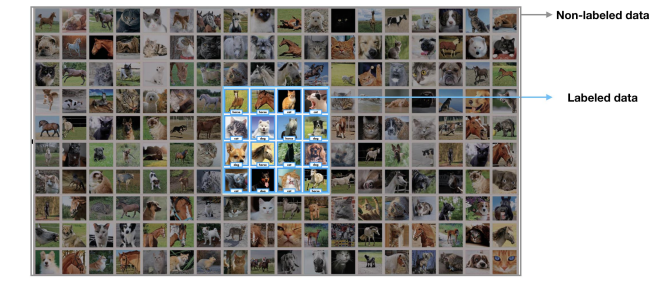

MixMatch는 Consistency Regularization, Entropy Minimization, Mix-UP이라는 아이디어를 혼합하여 학습데이터를 생성하는 알고리즘입니다. 전체적인 흐름을 그림으로 나타내면 다음과 같습니다.

<br>

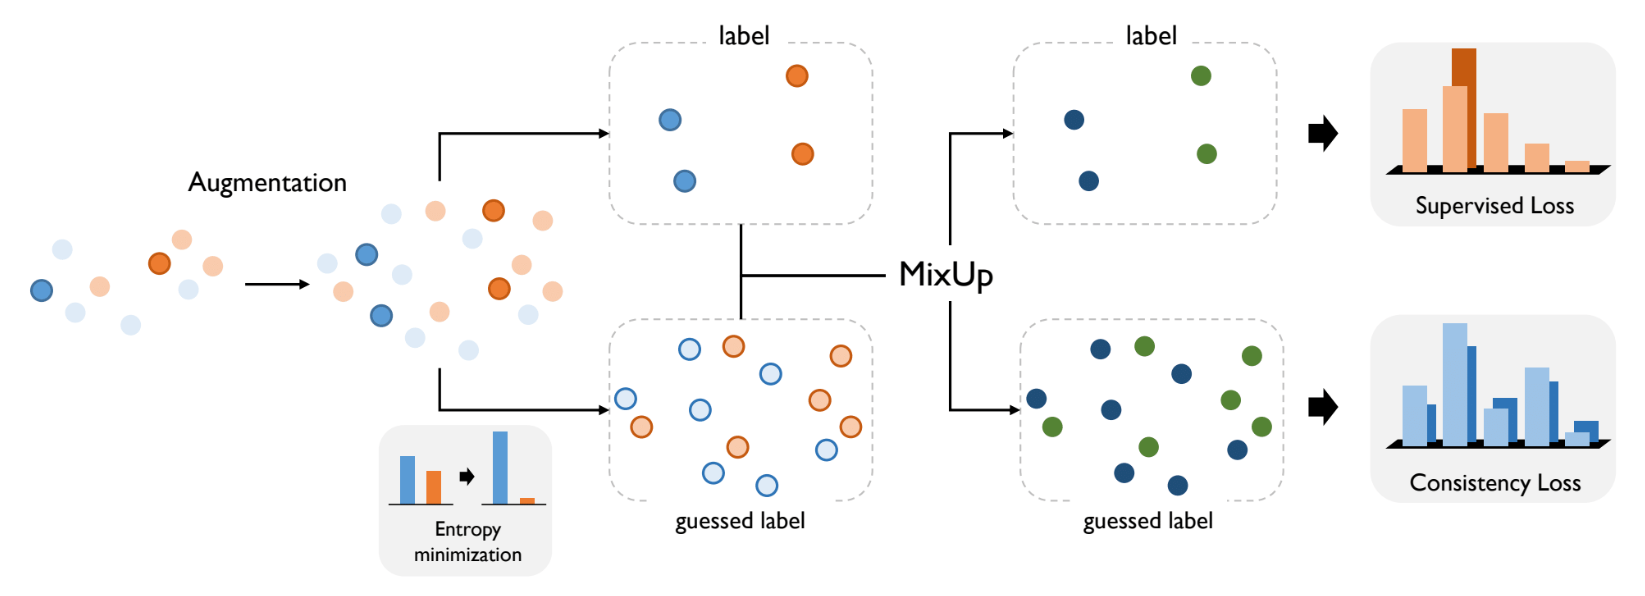

<br> 

각 개념들은 코드와 함께 천천히 살펴보도록 하겠습니다.😀

먼저 필요한 라이브러리를 불러옵니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.nn.functional as F
from itertools import chain, repeat


# 파라미터
num_labeled = 250
batch_size = 50
num_classes = 10
K=2
Soft_Temperature = 0.5
alpha=0.75

# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cifar10 데이터셋을 사용하겠습니다! CIFAR-10은 32 x 32 크기의 60000개의 이미지로 이루어져 있습니다. 10개의 클래스로 분류(airplane, bird, cat ...) 되며 총 50000개의 학습 데이터, 10000개의 테스트 데이터로 나뉩니다.

In [2]:
# transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cifar10 의 train과 testset 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  # 50000개
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  # 10000개

Files already downloaded and verified
Files already downloaded and verified


cifar10 데이터셋은 label이 모두 존재하기 때문에 train set을 임의로 labeled data와 unlabeled data로 나눠줘야겠죠?

In [3]:
labeled_set = torch.utils.data.Subset(trainset, range(num_labeled))
unlabeled_set = torch.utils.data.Subset(trainset, range(num_labeled, len(trainset)))

In [4]:
print('unlabeled set 크기 : ',len(unlabeled_set))
print('labeled set 크기 : ',len(labeled_set))

unlabeled set 크기 :  49750
labeled set 크기 :  250


labeled data는 250개로 해주었습니다.

## 💡 Data Augmentation
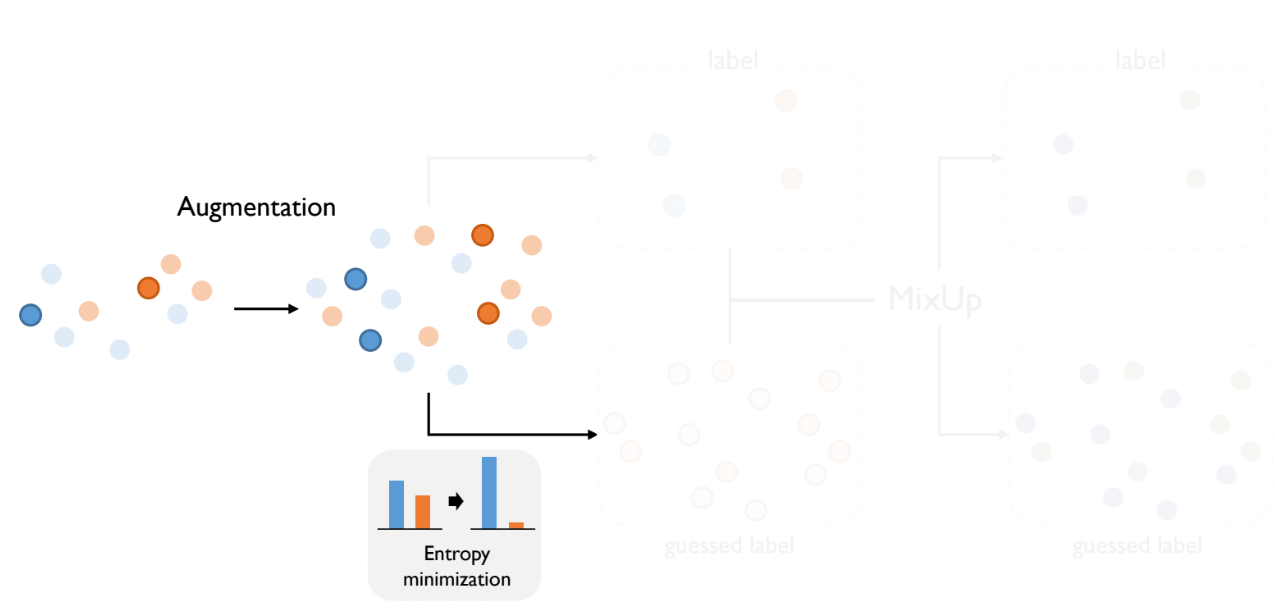

1) Labeled data에 사전에 정의한 Augmentation 방법중 하나만 임의로 선택하여 적용합니다. 이를 Stochastic Augmentation이라고 합니다. <br>
2) Unlabeled data에는 사전에 정의된 데이터 증강 기법을 K번 적용합니다. (아래 그림을 참고하시면 더 이해하기 쉬울 겁니다!)
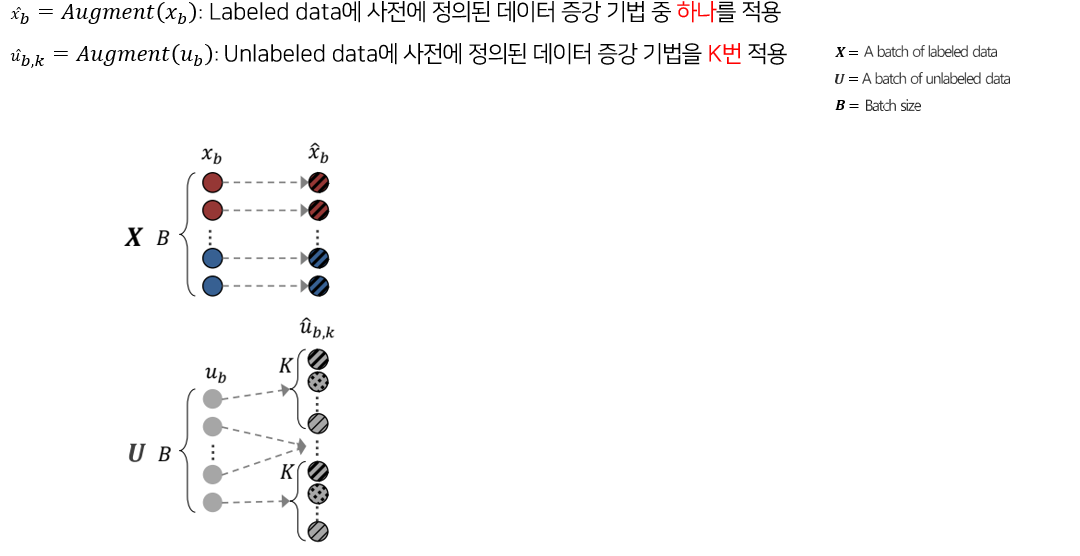

<br>
따라서 아래와 같은 Data Augmentation 단계를 거치면 B개의 Labeled data와 BxK개의 Unlabeled data가 생성됩니다.

In [5]:
def stochastic_augmentation(x, alpha=0.75, K=2):
    aug = []

    for _ in range(K):
        #0과 1 사이에서 랜덤 숫자 추출
        r = torch.rand(1).item()

        # alphan보다 작은 숫자라면 horizontal flip과 color jitter 적용
        if r < alpha:
            x_aug= torch.flip(x, dims=[-1])
            x_aug = torch.clamp(x_aug + torch.randn_like(x_aug) * 0.4, 0.0, 1.0)
        else:
            x_aug = x.clone() # 아니면 그대로

        aug.append(x_aug)

    return aug
                            

# labeled data에 augmentation 적용
labeled_set_aug = []
for x, y in labeled_set:
    augs = stochastic_augmentation(x, 0.75, 1)
    labeled_set_aug += [(x_aug, y) for x_aug in augs]
                                   
                                   
# unlabeled data에 augmentation 적용
unlabeled_set_aug = []
for x, _ in unlabeled_set:
    augs = stochastic_augmentation(x,0.75, K=K)
    unlabeled_set_aug += [augs]


In [6]:
# data loader 생성
labeled_loader = torch.utils.data.DataLoader(labeled_set, batch_size=batch_size, shuffle=True)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)
labeled_loader_aug = torch.utils.data.DataLoader(labeled_set_aug, batch_size=batch_size, shuffle=False)

## 💡 Label Guessing & Entropy Minimization

* **Consistency Regularization**이라는 개념을 설명드리겠습니다. 이는 증강된 unlabeled data를 학습에 활용하는 semi-supervised learning 방법론으로 데이터/모델에 변형을 주어 다르게 도출된 예측값이더라도 같은 이미지에서 도출되었다면 비슷한 값을 같도록 제약하는 방식입니다.

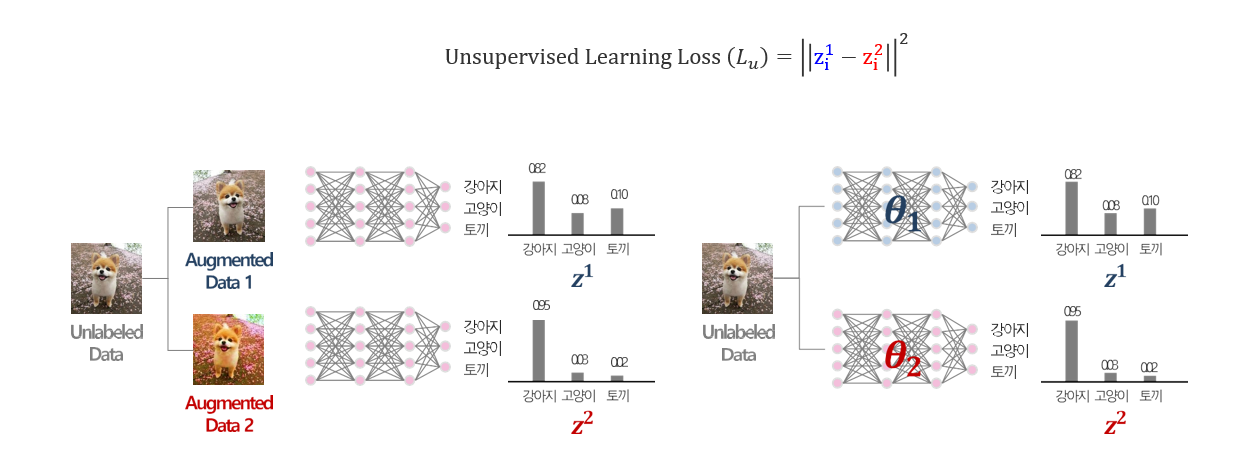

* **Entropy Minimization**란 Guessed label의 entropy를 최소화하는 개념으로 guessed label의 confidence를 증가시키는 것과 동일한 의미입니다.

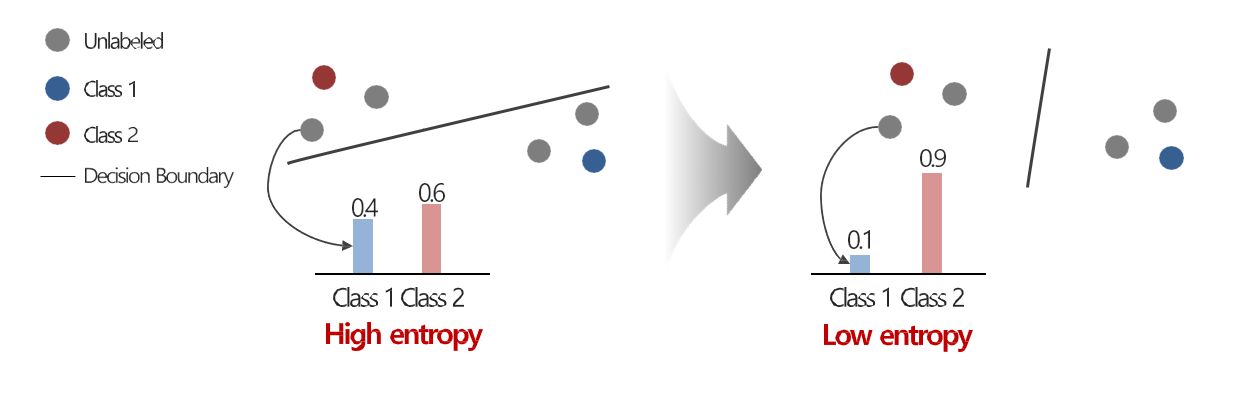


해당 단계에서는 <br>

1) Unlabeled data에 대한 K개의 예측 확률 값의 평균($𝑞 ̅_𝑏$)을 구하는데 이것이 바로 consistency regularization 개념을 적용한 것입니다. <br>
2) $𝑞 ̅_𝑏$에 Sharpening을 수행합니다. **Sharpening**은 Softmax Temperature를 이용한 Entropy minimization 방법을 의미합니다. <br>

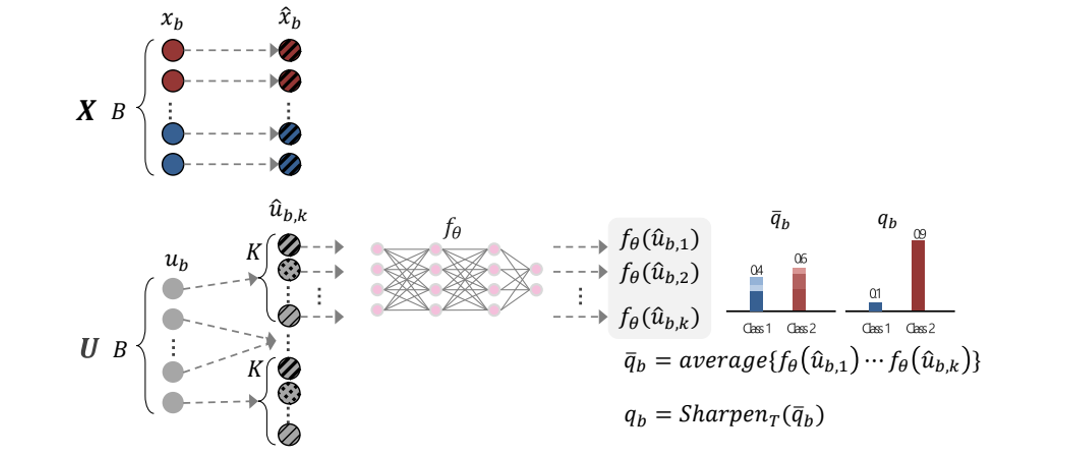

따라서 아래 코드처럼 모델을 정의하고 labeled data로 학습한 뒤

In [8]:
# model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Model().to(device)

# loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
# labeled data로 학습한 모델
for epoch in range(20):
    for X, y in labeled_loader_aug:
        X = X.to(device)
        y = y.to(device)
        
        output = model(X)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       


학습된 모델로 unlabeled data의 target을 예측하고 평균을 낸 뒤, Sharpening을 해줍니다.

In [10]:
# guess label
sharpen_list = []
for i in range(len(unlabeled_set_aug)) :
    k1 = unlabeled_set_aug[i][0].to(device)
    k2 = unlabeled_set_aug[i][1].to(device)   
    # Compute the predicted labels for the unlabeled data
    y_u_pred1 = model(k1)
    y_u_pred2 = model(k2)
    q = (y_u_pred1+y_u_pred2)/2
    
    #sharpening
    q = q.pow(1/Soft_Temperature)
    sharpen_list.append(q / q.sum(1))
    
# q_b       
sharpen_list = list(chain.from_iterable((repeat(s, 2) for s in sharpen_list)))        

## 💡 MixUp
* Labeled data와 Unlabeled data를 병합 (concat)한 후에 순서를 무작위로 재정렬(shuffle)해주는 단계입니다.

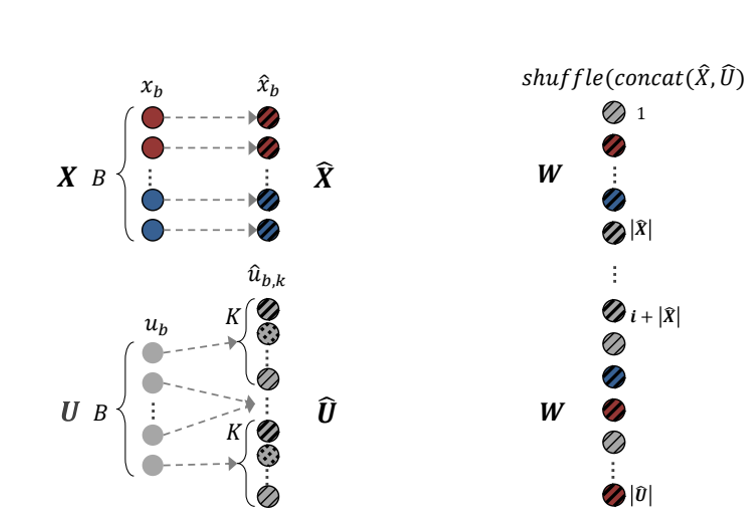

In [54]:
list_x = []
list_y = []
for X, y in labeled_loader_aug:
    list_x.append(X)
    list_y.append(y)

# x_hat_x
x_hat_x = torch.concat(([list_x[i] for i in range(5)]),0)
# x_hat_p
y_concat = torch.concat(([list_y[i] for i in range(5)]),0)
x_hat_p = F.one_hot(y_concat, num_classes=10).to(device)
# u_hat_p
u_hat_p = torch.stack([sharpen_list[i][0] for i in range(len(unlabeled_set_aug)*K)],0)
# u_hat_x
aug_x_list=list(chain.from_iterable((repeat(s, 2) for s in unlabeled_set_aug)))
u_hat_x = torch.stack([aug_x_list[i][0] for i in range(len(unlabeled_set_aug)*K)],0)

W와 X_hat과 U_hat를 생성합니다.

In [72]:
u_hat= torch.concat((x_hat_p,u_hat_p),0)
x_hat= torch.concat((x_hat_x,u_hat_x),0)
# suffle
idx = torch.randperm(Wp.shape[0]) 
Wp =u_hat[idx]
Wx =x_hat[idx]

그리고 Labeled data와 Unlabeled data 모두를 대상으로 Mix-Up 수행합니다. 

<br>

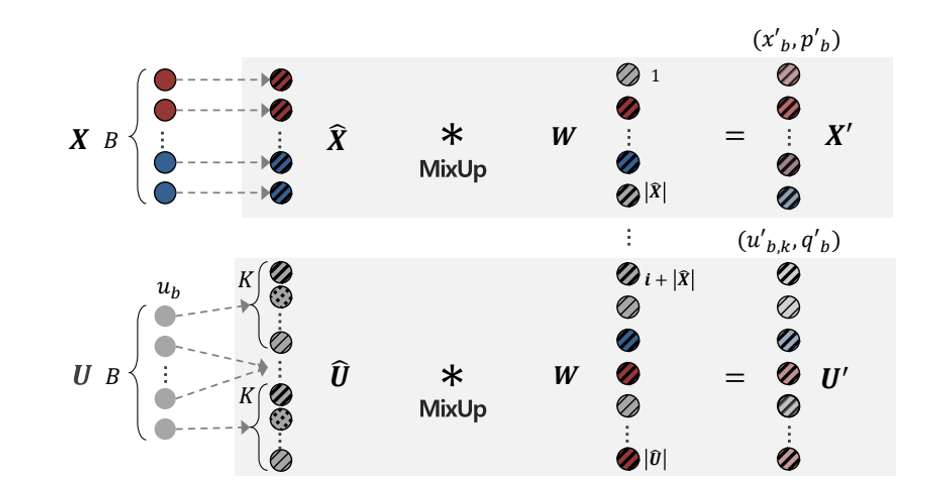


In [81]:
# Mixup
beta_dis = torch.distributions.beta.Beta(alpha, alpha)
lam = beta_dis.sample().item()
lam = max(lam, 1-lam)
x_prime = lam * x_hat + (1-lam) * Wx
u_prime = lam * u_hat + (1-lam) * Wp

In [87]:
x, p = x_prime[:len(x_hat_x)], u_prime[:len(x_hat_x)] # X'
u, q = x_prime[len(x_hat_x):], u_prime[len(x_hat_x):] #U'

MixMatch를 거쳐서 새로운 Labeled, Unlabeled 데이터들이 생성되었습니다~~~ 🙂 <Br> 
    
이렇게 생성된 데이터 중  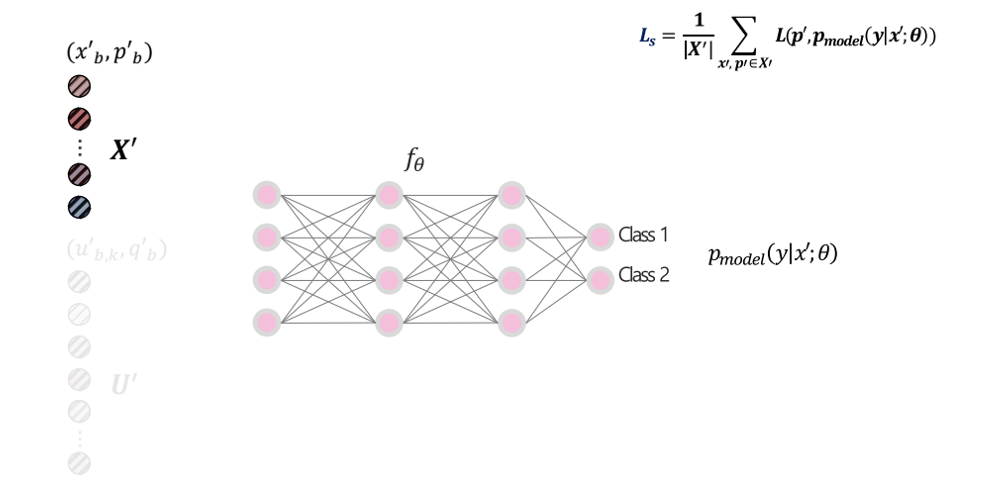 <br>


X' 으로 새로운 모델을 학습시켜 Supervised Loss를 구하고

<br>

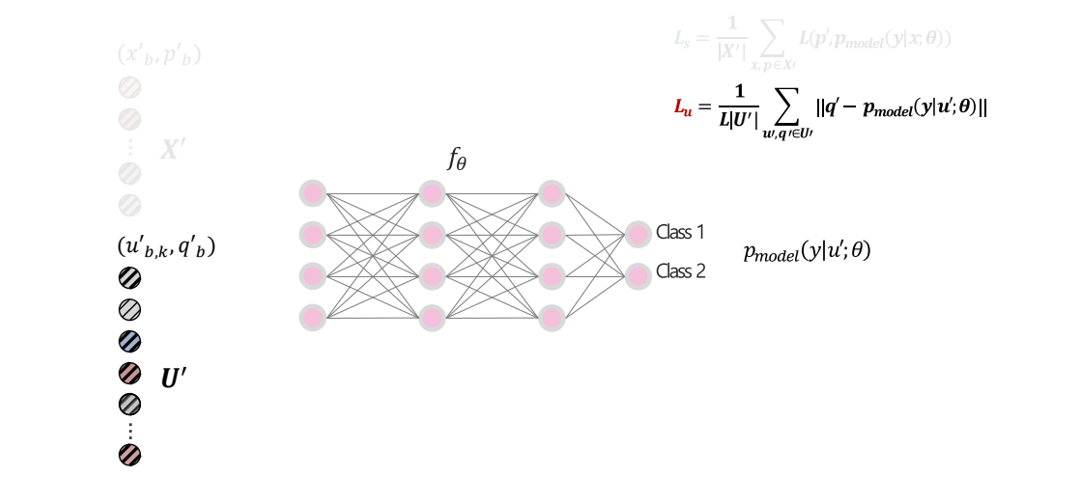
U'으로 학습시켜 Unsupervised Loss를 구하면 됩니다.

<br>

최종 loss는 두 가지의 Loss를 더한 것이 됩니다~~~ 😎

<br>

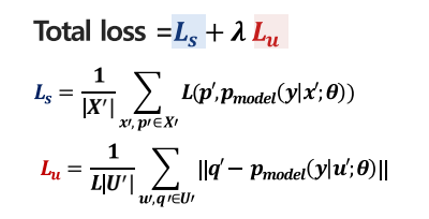

## 마무리
* 처음부터 공식만 보고 코드를 짜려니 잘 안되네요 ㅎㅎ 하지만 알고리즘의 흐름을 하나하나 천천히 뜯어보는데는 도움이 정말 많이 되었습니다. 추후에는 공식 코드를 가져와서 실제로 라벨이 없는 데이터에 해당 알고리즘을 적용해보면 좋을 것 같습니다.

* 모델에 새로 생성된 데이터로 훈련시키는 코드를 짜지못해서 아쉬운대로 [다른 코드](https://github.com/YU1ut/MixMatch-pytorch)를 가져와서 돌려보겠습니다. 해당 코드는 WideResnet을 사용하였습니다.

In [2]:
%run ./train.py

==> Preparing cifar10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
#Labeled: 250 #Unlabeled: 44750 #Val: 5000
==> creating WRN-28-2
    Total params: 1.47M

Epoch: [1 | 20] LR: 0.002000

Epoch: [2 | 20] LR: 0.002000

Epoch: [3 | 20] LR: 0.002000

Epoch: [4 | 20] LR: 0.002000

Epoch: [5 | 20] LR: 0.002000

Epoch: [6 | 20] LR: 0.002000

Epoch: [7 | 20] LR: 0.002000

Epoch: [8 | 20] LR: 0.002000

Epoch: [9 | 20] LR: 0.002000

Epoch: [10 | 20] LR: 0.002000

Epoch: [11 | 20] LR: 0.002000

Epoch: [12 | 20] LR: 0.002000

Epoch: [13 | 20] LR: 0.002000

Epoch: [14 | 20] LR: 0.002000

Epoch: [15 | 20] LR: 0.002000

Epoch: [16 | 20] LR: 0.002000

Epoch: [17 | 20] LR: 0.002000

Epoch: [18 | 20] LR: 0.002000

Epoch: [19 | 20] LR: 0.002000

Epoch: [20 | 20] LR: 0.002000
Best acc:
71.82
Mean acc:
63.708499999999994


Mixmatch 논문에서는  13-layer convolutional network를 사용해서 85.69%의 정확도를 보여주었는데 해당 코드는 71%정도의 성능이 나오는 것을 확인하였습니다. 모델 종류에 따라서도 성능차이가 많이 나는지 확인해보면 좋을 것 같습니다.